# Predicting Wine Quality with Several Classification Techniques

In [1]:
# This notebook demonstrates a complete machine learning pipeline for predicting wine quality using classification algorithms. We'll:
# - Download and combine red/white wine datasets
# - Perform thorough exploratory data analysis
# - Preprocess data for modeling
# - Train and tune 4 classification models
# - Evaluate performance with multiple metrics
# - Analyze feature importance

# Business Impact: Winemakers can use this model to identify key quality drivers during production, reducing waste and improving premium product yield.

# Imports & Setup

In [2]:
# Standard data science libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

# Data download
import requests
from io import StringIO
import os
from pathlib import Path

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Download and Load Data

In [3]:
def download_wine_data():
    data_dir = Path('data')
    data_dir.mkdir(exist_ok=True)

    urls = {
        'red': 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
        'white': 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
    }

    dfs = {}
    for wine_type, url in urls.items():
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()

            # Save raw data
            filename = data_dir / f"winequality-{wine_type}.csv"
            with open(filename, 'w') as f:
                f.write(response.text)

            # Read into DataFrame
            dfs[wine_type] = pd.read_csv(StringIO(response.text), sep=';')
            dfs[wine_type]['wine_type'] = wine_type

            print(f"Successfully downloaded {wine_type} wine data")

        except requests.exceptions.RequestException as e:
            raise ConnectionError(f"Failed to download {wine_type} wine data: {str(e)}")
        except Exception as e:
            raise RuntimeError(f"Error processing {wine_type} wine data: {str(e)}")

    return dfs

# Execute download
try:
    wine_dfs = download_wine_data()

    # Combine datasets
    wine_df = pd.concat(wine_dfs, ignore_index=True)
    print(f"Combined dataset shape: {wine_df.shape}")

except Exception as e:
    print(f"Fatal error: {str(e)}")
    raise

Successfully downloaded red wine data
Successfully downloaded white wine data
Combined dataset shape: (6497, 13)


# Basic Info & Stats

In [4]:
# Basic dataset information
print("Dataset Information")
print(f"Total samples: {len(wine_df)}")
print(f"Red wines: {len(wine_df[wine_df['wine_type'] == 'red'])}")
print(f"White wines: {len(wine_df[wine_df['wine_type'] == 'white'])}")
print("\n Data Types")
print(wine_df.info())
print("\n Statistical Summary")
display(wine_df.describe().T)

Dataset Information
Total samples: 6497
Red wines: 1599
White wines: 4898

 Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)


,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.000,7.215,1.296,3.800,6.400,7.000,7.700,15.900
volatile acidity,6497.000,0.340,0.165,0.080,0.230,0.290,0.400,1.580
citric acid,6497.000,0.319,0.145,0.000,0.250,0.310,0.390,1.660
residual sugar,6497.000,5.443,4.758,0.600,1.800,3.000,8.100,65.800
chlorides,6497.000,0.056,0.035,0.009,0.038,0.047,0.065,0.611
free sulfur dioxide,6497.000,30.525,17.749,1.000,17.000,29.000,41.000,289.000
total sulfur dioxide,6497.000,115.745,56.522,6.000,77.000,118.000,156.000,440.000
density,6497.000,0.995,0.003,0.987,0.992,0.995,0.997,1.039
pH,6497.000,3.219,0.161,2.720,3.110,3.210,3.320,4.010
sulphates,6497.000,0.531,0.149,0.220,0.430,0.510,0.600,2.000


# Missing Values & Duplicates

In [5]:
# Check for missing values and duplicates
print("Missing Values")
print(wine_df.isnull().sum())
print("\n Duplicate Rows")
print(f"Total duplicates: {wine_df.duplicated().sum()}")

# Remove duplicates
initial_count = len(wine_df)
wine_df = wine_df.drop_duplicates().reset_index(drop=True)
removed_count = initial_count - len(wine_df)
print(f"Removed {removed_count} duplicate rows")

Missing Values
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_type               0
dtype: int64

 Duplicate Rows
Total duplicates: 1177
Removed 1177 duplicate rows


# Target Distribution

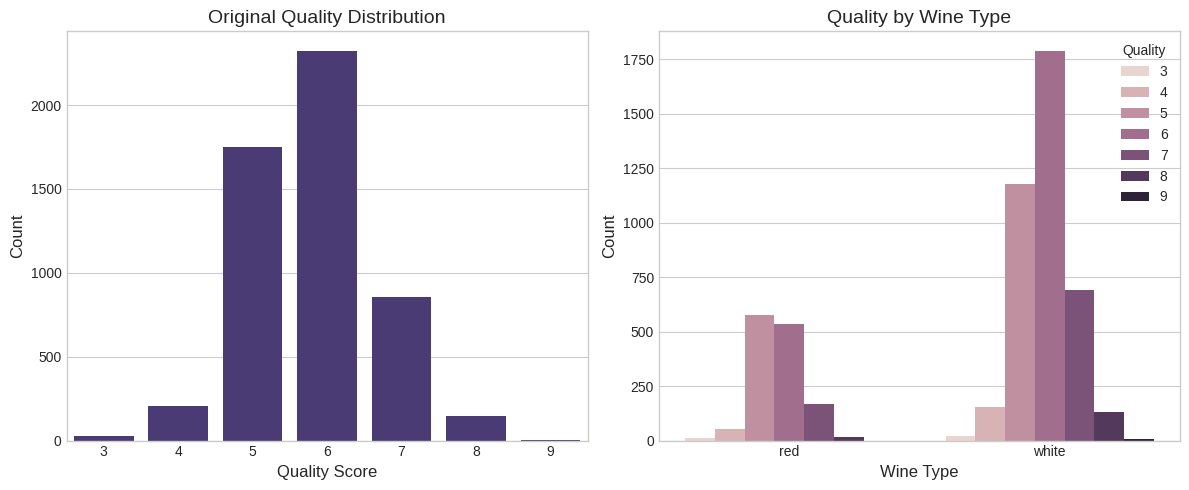

Quality Distribution Analysis
Original quality classes: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


In [6]:
# Target variable distribution (original)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='quality', data=wine_df)
plt.title('Original Quality Distribution', fontsize=14)
plt.xlabel('Quality Score', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(1, 2, 2)
sns.countplot(x='wine_type', hue='quality', data=wine_df)
plt.title('Quality by Wine Type', fontsize=14)
plt.xlabel('Wine Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Quality')

plt.tight_layout()
plt.show()

print("Quality Distribution Analysis")
print(f"Original quality classes: {sorted(wine_df['quality'].unique())}")

# Feature Distributions

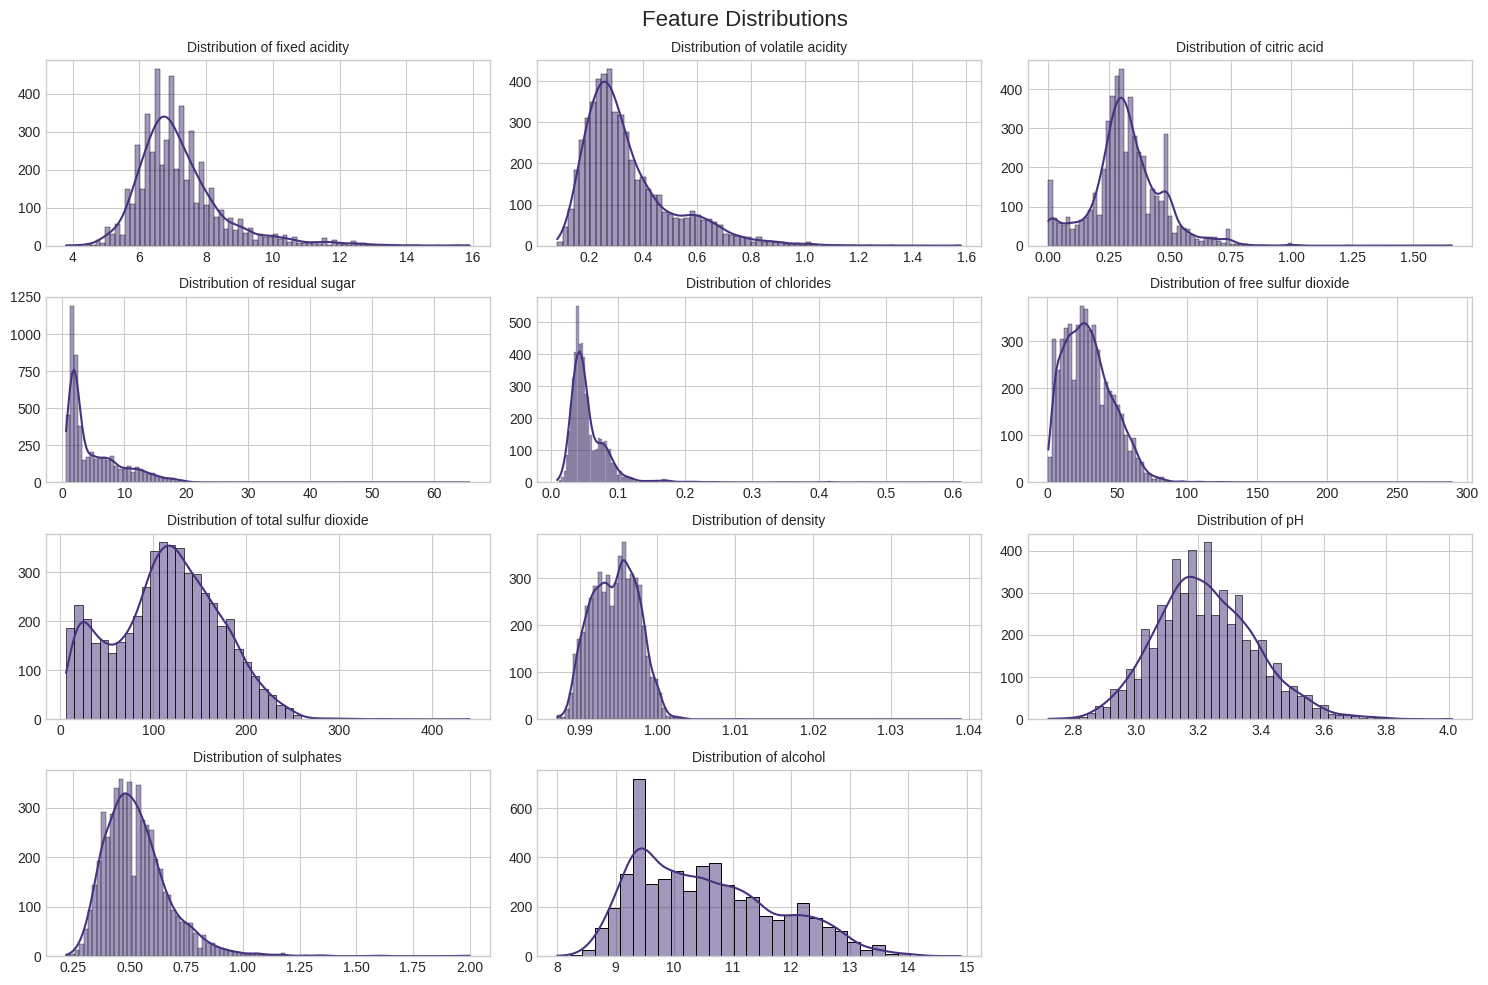

In [7]:
# Feature distributions
plt.figure(figsize=(15, 10))
numerical_cols = wine_df.select_dtypes(include=np.number).columns.drop('quality')

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(wine_df[col], kde=True)
    plt.title(f'Distribution of {col}', fontsize=10)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle('Feature Distributions', fontsize=16, y=0.98)
plt.subplots_adjust(top=0.93)
plt.show()

# Correlation Heatmap

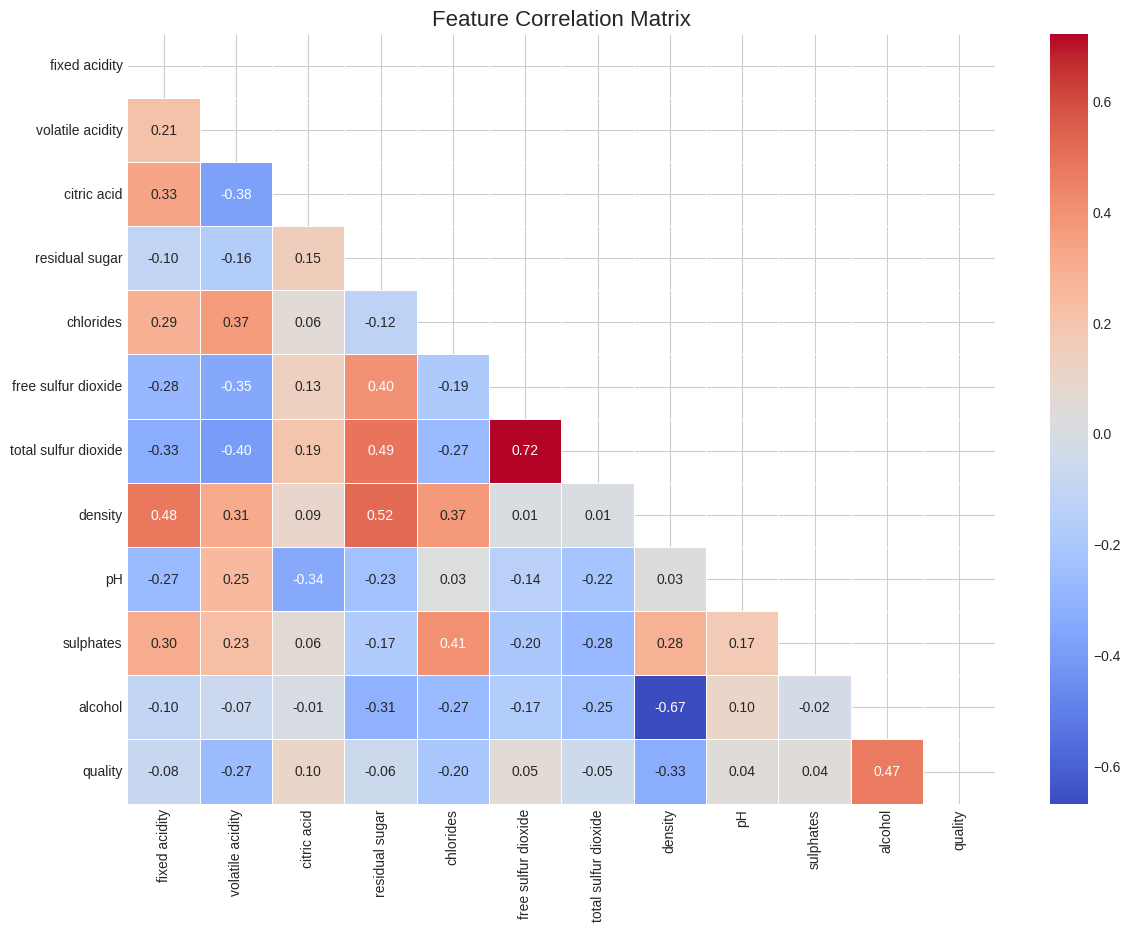

Key Correlation Insights
Most positively correlated with quality: alcohol (0.47)
Most negatively correlated with quality: density (-0.33)


In [8]:
# Correlation analysis
plt.figure(figsize=(14, 10))
corr = wine_df.drop('wine_type', axis=1).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

print("Key Correlation Insights")
quality_corr = corr['quality'].drop('quality')
most_pos = quality_corr.idxmax()
most_neg = quality_corr.idxmin()
print(f"Most positively correlated with quality: {most_pos} ({quality_corr[most_pos]:.2f})")
print(f"Most negatively correlated with quality: {most_neg} ({quality_corr[most_neg]:.2f})")

# Boxplots vs Quality

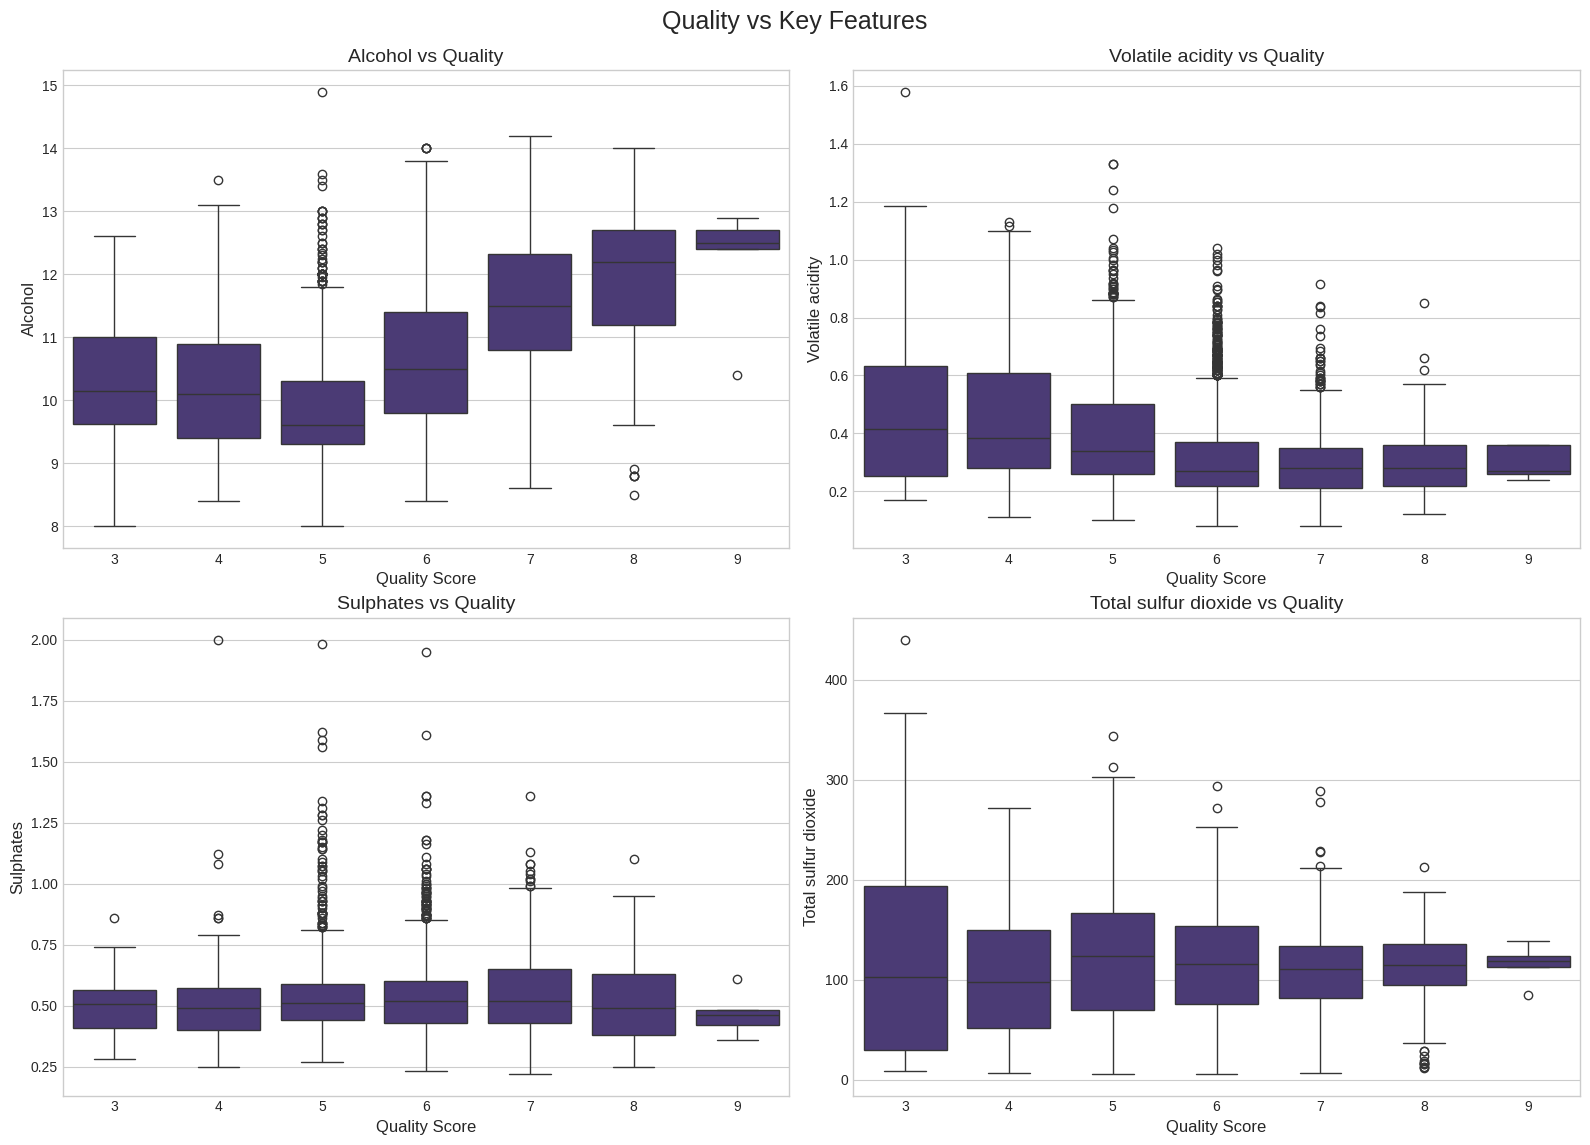

In [9]:
# Boxplots for key features vs quality
plt.figure(figsize=(16, 12))
key_features = ['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide']

for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='quality', y=feature, data=wine_df)
    plt.title(f'{feature.capitalize()} vs Quality', fontsize=14)
    plt.xlabel('Quality Score', fontsize=12)
    plt.ylabel(feature.capitalize(), fontsize=12)

plt.tight_layout()
plt.suptitle('Quality vs Key Features', fontsize=18, y=0.95)
plt.subplots_adjust(top=0.9)
plt.show()

# Preprocessing

In [10]:
# Convert wine_type to numeric (one-hot encoding)
wine_df = pd.get_dummies(wine_df, columns=['wine_type'], drop_first=True)
wine_df = wine_df.rename(columns={'wine_type_white': 'is_white'})

# Create binary target: quality > 6 is 'good' (1), else 'bad' (0)
wine_df['quality_binary'] = (wine_df['quality'] > 6).astype(int)
print("Binary target distribution:")
print(wine_df['quality_binary'].value_counts(normalize=True))

# Define features and target
X = wine_df.drop(columns=['quality', 'quality_binary'])
y = wine_df['quality_binary']

# Split data (stratify to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Binary target distribution:
quality_binary
0   0.810
1   0.190
Name: proportion, dtype: float64
Training set: 4256 samples
Test set: 1064 samples


# Standardization

In [11]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Evaluation Function

In [12]:
def train_evaluate_model(model, params, X_train, y_train, X_test, y_test, model_name):

    # Hyperparameter tuning
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Evaluation metrics
    print(f"\n{model_name} Results")
    print(f"Best Parameters: {grid.best_params_}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Bad', 'Good'],
                yticklabels=['Bad', 'Good'])
    plt.title(f'{model_name} Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    return {
        'model': best_model,
        'f1': grid.best_score_,
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

# Logistic Regression


Logistic Regression Results
Best Parameters: {'C': 0.1, 'max_iter': 1000, 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       862
           1       0.39      0.79      0.53       202

    accuracy                           0.73      1064
   macro avg       0.67      0.75      0.67      1064
weighted avg       0.83      0.73      0.76      1064



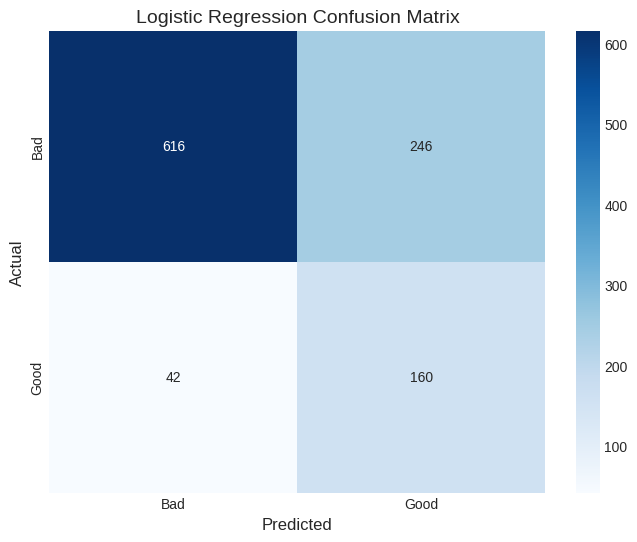

In [13]:
lr_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}
lr_results = train_evaluate_model(
    LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'),
    lr_params,
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    'Logistic Regression'
)

# Random Forest


Random Forest Results
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       862
           1       0.53      0.64      0.58       202

    accuracy                           0.82      1064
   macro avg       0.72      0.75      0.73      1064
weighted avg       0.84      0.82      0.83      1064



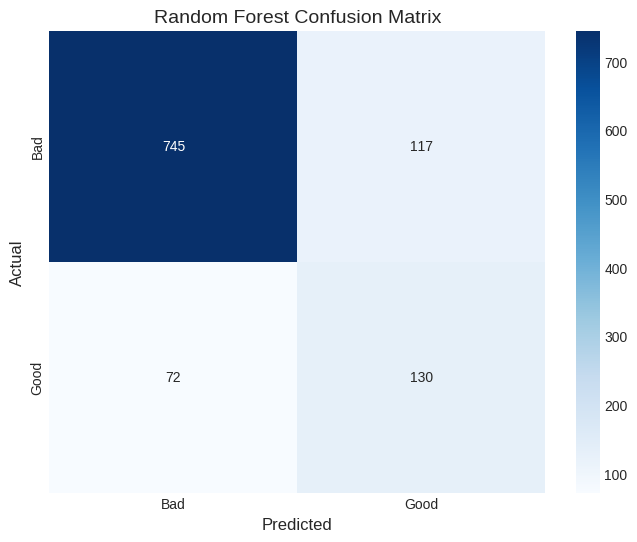

In [14]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_results = train_evaluate_model(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    rf_params,
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    'Random Forest'
)

# SVM


Support Vector Machine Results
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       862
           1       0.41      0.83      0.55       202

    accuracy                           0.74      1064
   macro avg       0.68      0.77      0.68      1064
weighted avg       0.84      0.74      0.76      1064



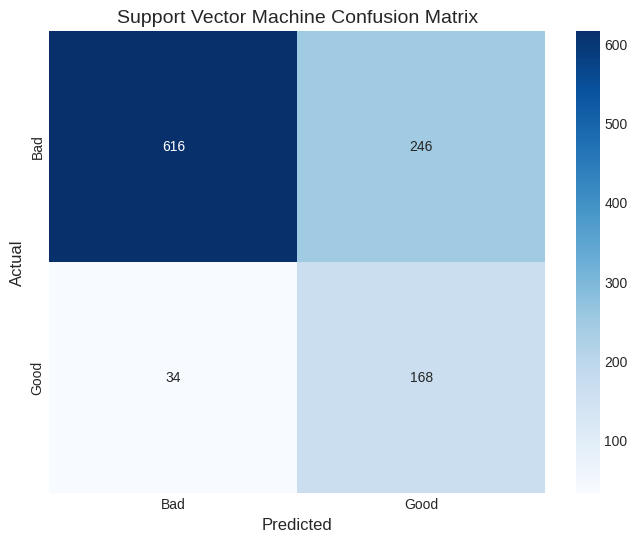

In [15]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}
svm_results = train_evaluate_model(
    SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced'),
    svm_params,
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    'Support Vector Machine'
)

# XGBoost


XGBoost Results
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       862
           1       0.62      0.38      0.47       202

    accuracy                           0.84      1064
   macro avg       0.74      0.66      0.69      1064
weighted avg       0.82      0.84      0.82      1064



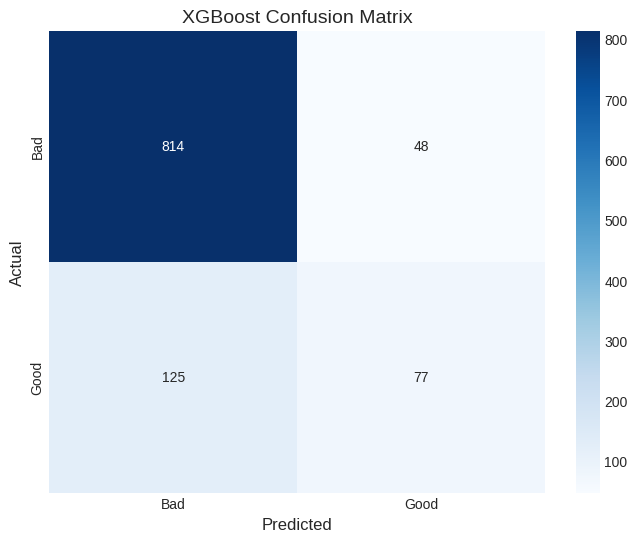

In [16]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}
xgb_results = train_evaluate_model(
    XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
    xgb_params,
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    'XGBoost'
)

# Model Comparison


 Model Comparisoin


,Model,F1 Score (CV),AUC Score
0,Logistic Regression,0.539,0.817
1,Random Forest,0.564,0.861
2,SVM,0.545,0.854
3,XGBoost,0.481,0.865


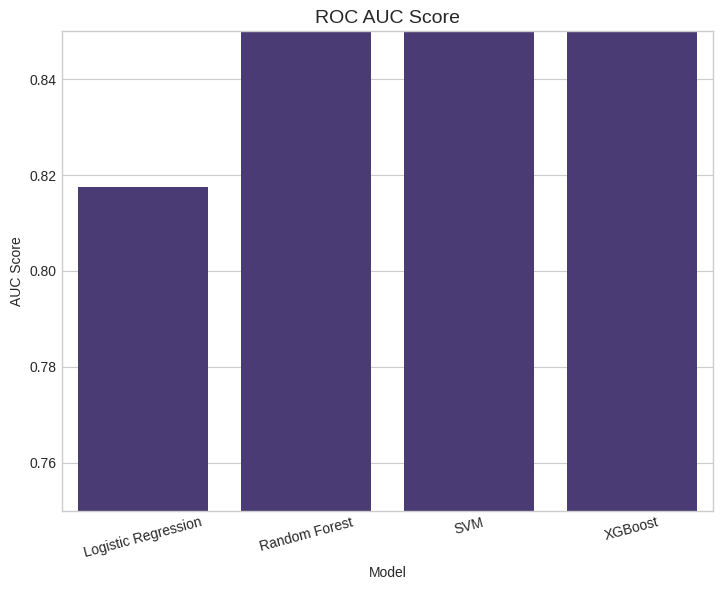

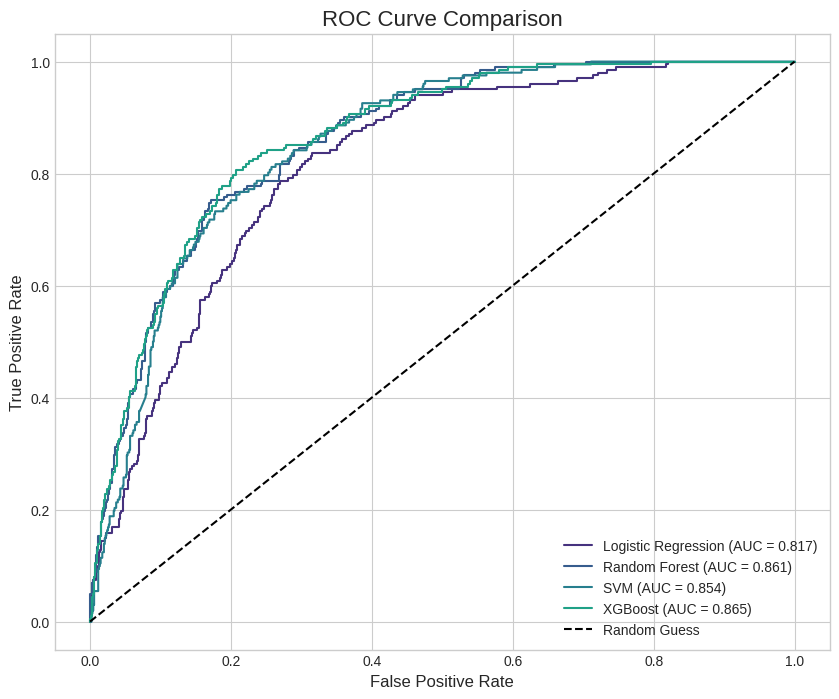

In [17]:
# Compare model performance
models = [
    ('Logistic Regression', lr_results),
    ('Random Forest', rf_results),
    ('SVM', svm_results),
    ('XGBoost', xgb_results)
]

# Create comparison DataFrame
results_df = pd.DataFrame([
    {
        'Model': name,
        'F1 Score (CV)': res['f1'],
        'AUC Score': res['auc']
    } for name, res in models
])

print("\n Model Comparisoin")
display(results_df)

# Visualize performance comparison
plt.figure(figsize=(14, 6))


plt.subplot(1, 2,1)
sns.barplot(x='Model', y='AUC Score', data=results_df)
plt.title('ROC AUC Score', fontsize=14)
plt.xticks(rotation=15)
plt.ylim(0.75, 0.85)

plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, res in models:
    plt.plot(res['fpr'], res['tpr'], label=f'{name} (AUC = {res["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.show()

# Feature Importance

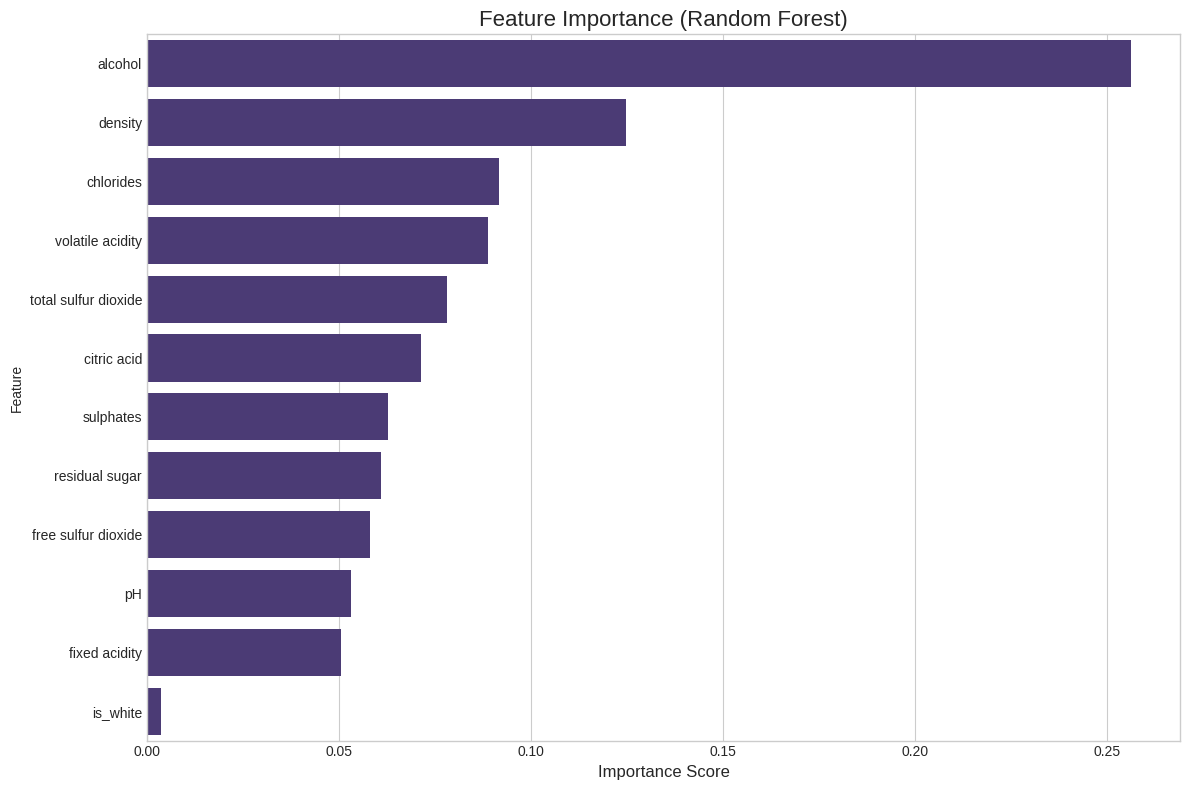

Top 5 Quality Drivers


,Feature,Importance
10,alcohol,0.256
7,density,0.125
4,chlorides,0.092
1,volatile acidity,0.089
6,total sulfur dioxide,0.078


In [18]:
# Feature importance analysis (Random Forest)
rf_model = rf_results['model']
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    features = X.columns

    # Create DataFrame for visualization
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance (Random Forest)', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("Top 5 Quality Drivers")
    display(importance_df.head())
else:
    print("Feature importance not available for this model type")